In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import read_csv
import math
import seaborn as sns

2023-06-19 18:29:06.531326: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df1 = pd.read_csv('/uscms/home/jieun201/nobackup/YOURWORKINGAREA/dec14_ysize/FullPrecisionInputTrainSet.csv')
df1

,y-size,y-local
0,2,6.082510
1,3,3.385020
2,3,2.585680
3,2,6.084500
4,3,3.180250
...,...,...
652155,3,0.679302
652156,5,-0.719806
652157,5,-6.042060
652158,2,4.781100


In [3]:
df2 = pd.read_csv('/uscms/home/jieun201/nobackup/YOURWORKINGAREA/dec6_ds8/TrainSetLabel.csv')
df2

,ptLabel
0,0
1,0
2,0
3,1
4,1
...,...
652155,1
652156,2
652157,0
652158,1


In [4]:
df3 = pd.read_csv('/uscms/home/jieun201/nobackup/YOURWORKINGAREA/dec14_ysize/FullPrecisionInputTestSet.csv')
df4 = pd.read_csv('/uscms/home/jieun201/nobackup/YOURWORKINGAREA/dec6_ds8/TestSetLabel.csv')

In [5]:
X_train = df1.values
X_test = df3.values

y_train = df2.values
y_test = df4.values
#X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state = 0)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(652160, 2) (163040, 2) (652160, 1) (163040, 1)


In [6]:
y_train

array([[0],
       [0],
       [0],
       ...,
       [0],
       [1],
       [1]])

In [7]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [8]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(2,)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(3,activation='softmax')
])

model.compile(optimizer=Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), # default from_logits=False
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

model.summary()

es = EarlyStopping(monitor='val_sparse_categorical_accuracy', 
                                   mode='max', # don't minimize the accuracy!
                                   patience=20,
                                   restore_best_weights=True)

history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=200, 
                    batch_size=1024,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2)                 0         
                                                                 
 dense (Dense)               (None, 128)               384       
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 771
Trainable params: 771
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
510/510 [==============================] - 3s 3ms/step - loss: 0.7953 - sparse_categorical_accuracy: 0.6308 - val_loss: 0.7356 - val_sparse_categorical_accuracy: 0.6482
Epoch 2/200
510/510 [==============================] - 1s 3ms/step - loss: 0.7298 - sparse_categorical_accuracy: 0.6510 - val_loss: 0.7310 - 

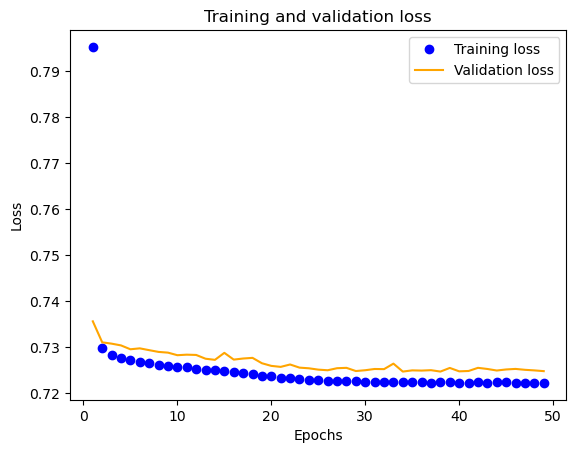

In [9]:
history_dict = history.history
loss_values = history_dict['loss'] 
val_loss_values = history_dict['val_loss'] 
epochs = range(1, len(loss_values) + 1) 
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/home/jieun201/dec14_ysize/loss.png')

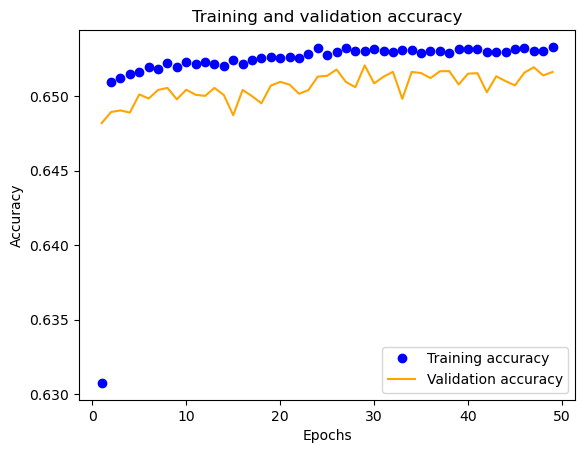

In [10]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
#np.max(val_acc)
plt.savefig('accuracy.png')
plt.savefig('/home/jieun201/dec14_ysize/accuracy.png')

In [11]:
preds = model.predict(X_test) 
predictionsFiles =np.argmax(preds, axis=1)

5095/5095 [==============================] - 5s 1ms/step


In [12]:
pd.DataFrame(predictionsFiles).to_csv("predictionsFiles.csv",header='predict', index=False)

In [13]:
pd.DataFrame(y_test).to_csv("true.csv",header='true', index=False)

In [14]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.7252229452133179
Test accuracy: 0.6542198061943054


Confusion matrix:
[[61442  9531 10547]
 [18904 20896   960]
 [16417    17 24326]]


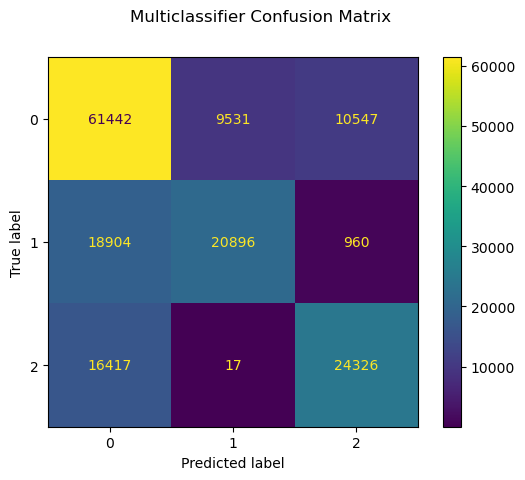

In [15]:
from sklearn import datasets, svm, metrics
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predictionsFiles)
disp.figure_.suptitle("Multiclassifier Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.savefig('confusionMatrix.png')
plt.show()